2017 Edition

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [3]:
!hdfs dfs -ls /datasets/gutenberg

Found 2 items
-rw-r--r--   5 root supergroup 3000000000 2016-03-30 08:36 /datasets/gutenberg/gutenberg_small.txt
-rw-r--r--   3 root supergroup   31457280 2017-02-28 13:34 /datasets/gutenberg/gutenberg_tiny.txt


In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: {}s".format(time.time() - time_start))
print(words.take(5))

Runtime: 293.69857025146484s
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: {}s".format(time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 145.55229878425598s


<div class="alert alert-block alert-info">

<strong>Answer 1.</strong> 

Executing the two snippets we obtained a run time for the DataFrame API wich is about half the time of the common RDD code. This is expected because the DataFrame API forces a structure to the data (schema), allowing faster aggregation. Moreover, the execution is supported by the Catalyst optimizer, that enanched the execution of the query.

</div>

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an RDD[String]. We need to transform it to RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)] then call a function to create a DataFrame from the new RDD. Please note that, package com.databricks.spark.csv can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.

In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that CRSDepTime to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [6]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(), True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [7]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[0] else None,
            int(cols[1])  if cols[1] else None,
            int(cols[2])  if cols[2] else None,
            int(cols[3])  if cols[3] else None,
            int(cols[4])  if cols[4] else None,
            int(cols[5])  if cols[5] else None,
            int(cols[6])  if cols[6] else None,
            int(cols[7])  if cols[7] else None,
            cols[8]       if cols[8] else None,
            cols[9]       if cols[9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [8]:
night_flights = df[df.scheduled_departure_time > 1800].count()
print("There are", str(night_flights), "night flights.")

There are 1078203 night flights.


In [9]:
night_flights_per_carrier = df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0)
night_flights_per_carrier.show()

+-------+------+
|carrier| count|
+-------+------+
|     DL|208224|
|     US|170397|
|     AA|142832|
|     WN|124024|
|     UA|113640|
|     NW|100453|
|     CO| 94501|
|     TW| 54771|
|     HP| 44351|
|     AS| 25010|
+-------+------+



# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?
  
- Other interesting queries
  - Is there a difference between the various carriers in terms of distance of flights? (some carriers may only offer national flights while others could take care more of the international ones)
  - Is there a relation between the distance of flight and the delay?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [10]:
# Query 2.1.1
src_airports = (df.select(df.src_airport)
       .distinct()
       .count())
print("There are", str(src_airports), "origin airports.")

There are 224 origin airports.


In [11]:
# Query 2.1.2
dst_airports = (df.select(df.dest_airport)
       .distinct()
       .count())
print("There are", str(dst_airports), "destination airports.")

There are 225 destination airports.


### Answer 2.1
<div class="alert alert-info">
From the result of the queries it can be noticed that there are more destination airports than origin ones. It will be seen in the last queries of the notebook that SPN is a source airport that does not belong to the origin while BFI and GUM are destinations not present in the origins.
</div>

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [12]:
# Query 2.2
car = (df.select(df.carrier)
       .distinct()
       .count())
print("There are", str(car), "unique carriers.")

There are 10 unique carriers.


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [13]:
# Query 2.3.1
night_flights = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()
print("There are", str(night_flights), "night flights.")

There are 1121918 night flights.


In [14]:
# Query 2.3.2
perc_night_flights = df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()/df.count()
print("The percentage of night flights is:", str(perc_night_flights*100), "%.")

The percentage of night flights is: 21.658447952605844 %.


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>

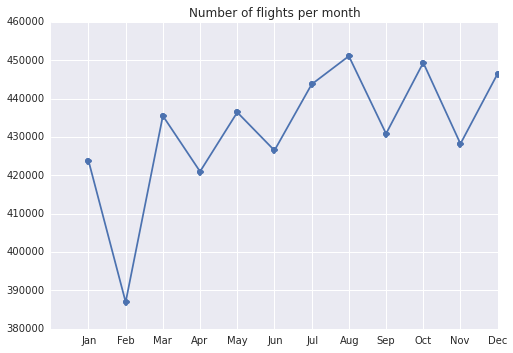

In [16]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# QUERY
# groupBy month and count the rows for each group. Then order by month to simplify the plotting.
# we have never grouped by year because we are considering only the 1994 dataset.
month_count = df.groupBy(df.month).count().orderBy(df.month)


# PRINT & COLLECT
month_count.show()
month_count = month_count.collect()

    
# Plot number of flights per month
plt.figure(figsize=(15,10))
plt.plot([x for x in range(len(months))], [x[1] for x in month_count], "-o")
plt.xticks([x for x in range(len(months))], months)
plt.xlim(0, len(months)-1)
plt.title('Number of flights per month')

plt.show()

### Answer 3.1: 

<div class="alert alert-info">
By looking at the produced line plot we can analize the flights trend with respect to each month of the year (on the x are reported the months, on the y the total number of flights).<br>
As expected, the number of flights increases during the summer months (in particular it reaches its maximum value in August) and in general during the holidays (in fact the second and third maximum values are in October and December).<br>
Instead, the month with less flights is February.<br>
Moreover, it's possibile to see that, in average, there are more flights in the second half of the year respect to the first half.<br>
</div>

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

In [17]:
# number of flights per day of the week
flights_dayofweek = (
    df.groupBy(df.day_of_week)
    .count()
    .orderBy('day_of_week')
    .collect()
)

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|754636|
|          2|756532|
|          3|756864|
|          4|751537|
|          5|751531|
|          6|695245|
|          7|713703|
+-----------+------+



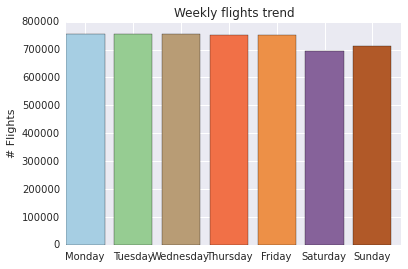

+-----+-----------+-----+
|month|day_of_week|count|
+-----+-----------+-----+
|    1|          1|70761|
|    1|          2|56327|
|    1|          3|55944|
|    1|          4|55870|
|    1|          5|56041|
|    1|          6|62488|
|    1|          7|66430|
|    2|          1|56645|
|    2|          2|56549|
|    2|          3|56460|
|    2|          4|56421|
|    2|          5|56823|
|    2|          6|50611|
|    2|          7|53445|
|    3|          1|57356|
|    3|          2|71424|
|    3|          3|71900|
|    3|          4|71942|
|    3|          5|57400|
|    3|          6|51347|
+-----+-----------+-----+
only showing top 20 rows



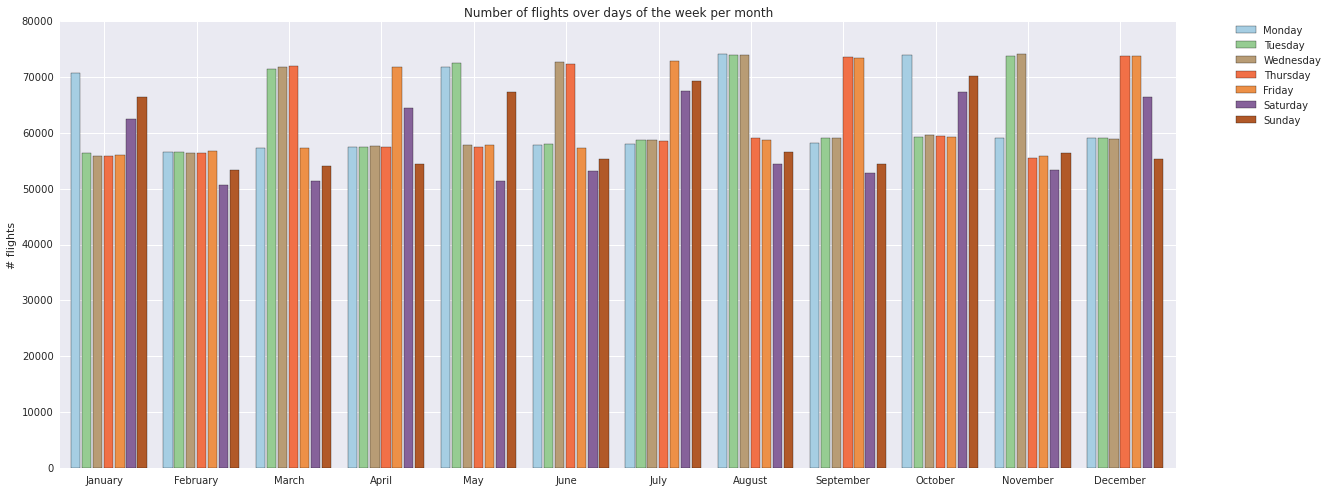

In [18]:
from matplotlib import cm

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
colors = cm.Paired(np.linspace(0, 1, 7))


### global aggregates ###

# QUERY
# groupby day of week and count the rows for each group. Then orderb by day of week to simplify plotting
days_count = df.groupBy(df.day_of_week).count().orderBy('day_of_week')


# PRINT & COLLECT
days_count.show()
days_count = days_count.collect()


# PLOT
plt.bar([x for x in range(len(days_of_week))], [x[1] for x in days_count], color=colors)
plt.xticks([x+0.4 for x in range(len(days_of_week))], days_of_week)
plt.title('Weekly flights trend')
plt.ylabel('# Flights')
plt.show()


### monthly aggregates ###

# QUERY
# groupby month and day of week, and count the rows for each group. In this way we may compute the count for each week for each month. 
# Then orderb by day of week to simplify plotting
days_count = df.groupBy(df.month, df.day_of_week).count().orderBy(df.month, df.day_of_week)


# PRINT & COLLECT
days_count.show()
days_count = days_count.collect()


# PLOT
pos = list(range(len(months)))
width = 0.12

fig, ax = plt.subplots(figsize=(20,8))

for d in range(len(days_of_week)):
    data_values = []
    for m in range(len(months)):
        data_values.append(days_count[m*len(days_of_week)+d][2])
    plt.bar([p + width*d for p in pos], data_values, width-0.02, color=colors[d])
    
ax.set_ylabel('# flights')
ax.set_title('Number of flights over days of the week per month')
ax.set_xticks([p + 3 * width for p in pos])
ax.set_xticklabels(months)
plt.xlim(min(pos)-width, max(pos)+width*(len(days_of_week)+1))

plt.legend(days_of_week, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


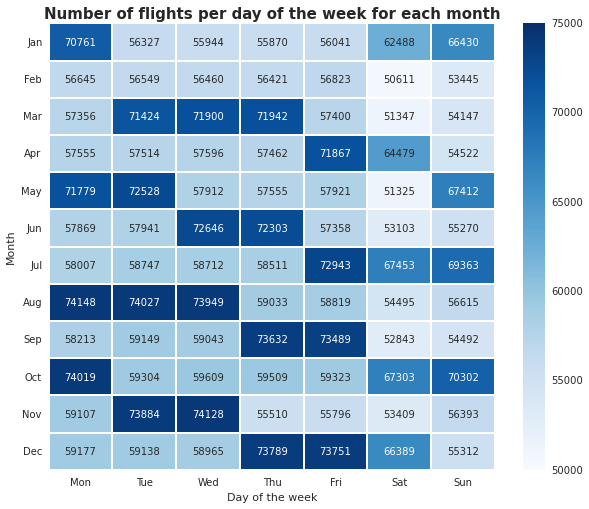

In [21]:
# use a heatmap to better visualize the data
pddf = pddf.pivot("month", "day_of_week", "flights")
fig, ax=plt.subplots(figsize=(10,8))
ax = sns.heatmap(pddf, 
                  linewidths=.5,
                  annot=True,
                  vmin=50000,
                  vmax=75000,
                  fmt='d',
                  cmap='Blues', ax=ax)
# set plot's labels
ax.set_xticklabels(daysofweek)
ax.set_yticklabels(list(reversed(months)), rotation=0)
ax.set(xlabel='Day of the week', ylabel='Month')
ax.set_title("Number of flights per day of the week for each month", fontweight="bold", size=15)

plt.show()

### Answer 3.2: 

<div class="alert alert-info">
The first plot shows that, over the year, the number of flights during the week days is generally stable while it decreases on Saturdays and Sundays.
<br>
<br>
The second bar plot delves into the details of each month. The pattern seen in the first plot doesn't actually apply to the monthly aggregates. In fact it can be noticed that each month has its own peaks, for example, in January there are more flights during Mondays and over the weekends while in March they are in the middle of the week.
<br>
<br>
Moreover, the heat map can offer a better data visualization to look for relevant information coming from the data. The map better shows the difference between week days and weekends, the highest number of flights are always during the week while the minimums are in the weekends, even if some weekends present increasing values in the months containing holidays like Christmas, Summer or the spring break.
<br>
<br>
Finally, a strange pattern comes out from this plot, showing that the days segment with higher number of flights shifts over the week for each month. Unfortunately, further deductions from this pattern would need the support of a bigger and wider data set.
</div>

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.
<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

+-----------+------+
|hour_of_day| count|
+-----------+------+
|          0| 13642|
|          1| 12825|
|          2|  2842|
|          3|   564|
|          4|   486|
|          5| 13357|
|          6|257486|
|          7|398796|
|          8|397060|
|          9|341597|
|         10|300375|
|         11|313577|
|         12|356830|
|         13|360762|
|         14|294214|
|         15|313131|
|         16|317809|
|         17|368695|
|         18|338147|
|         19|287033|
+-----------+------+
only showing top 20 rows



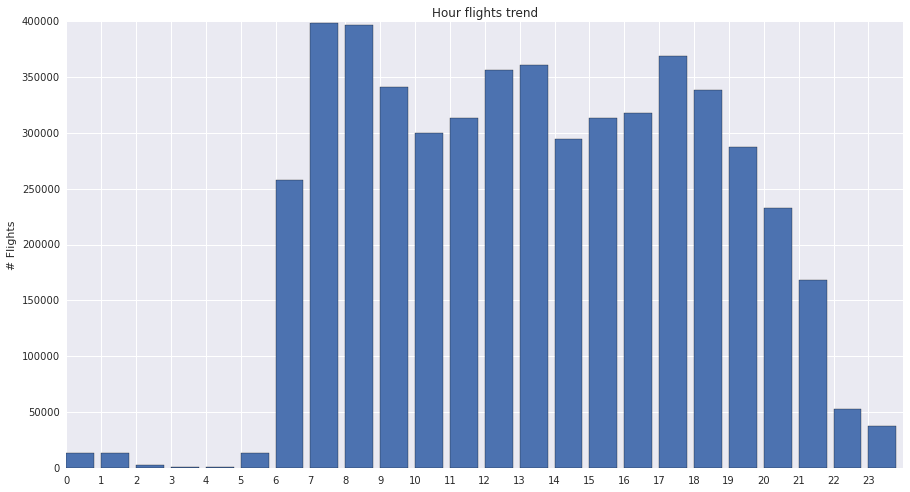

+-----+-----------+-----+
|month|hour_of_day|count|
+-----+-----------+-----+
|    1|          0| 1154|
|    1|          1|  901|
|    1|          2|  238|
|    1|          3|   62|
|    1|          4|   33|
|    1|          5| 1017|
|    1|          6|21360|
|    1|          7|31184|
|    1|          8|32814|
|    1|          9|28242|
|    1|         10|24073|
|    1|         11|26409|
|    1|         12|28302|
|    1|         13|30128|
|    1|         14|24179|
|    1|         15|25659|
|    1|         16|26598|
|    1|         17|30522|
|    1|         18|27939|
|    1|         19|23358|
+-----+-----------+-----+
only showing top 20 rows



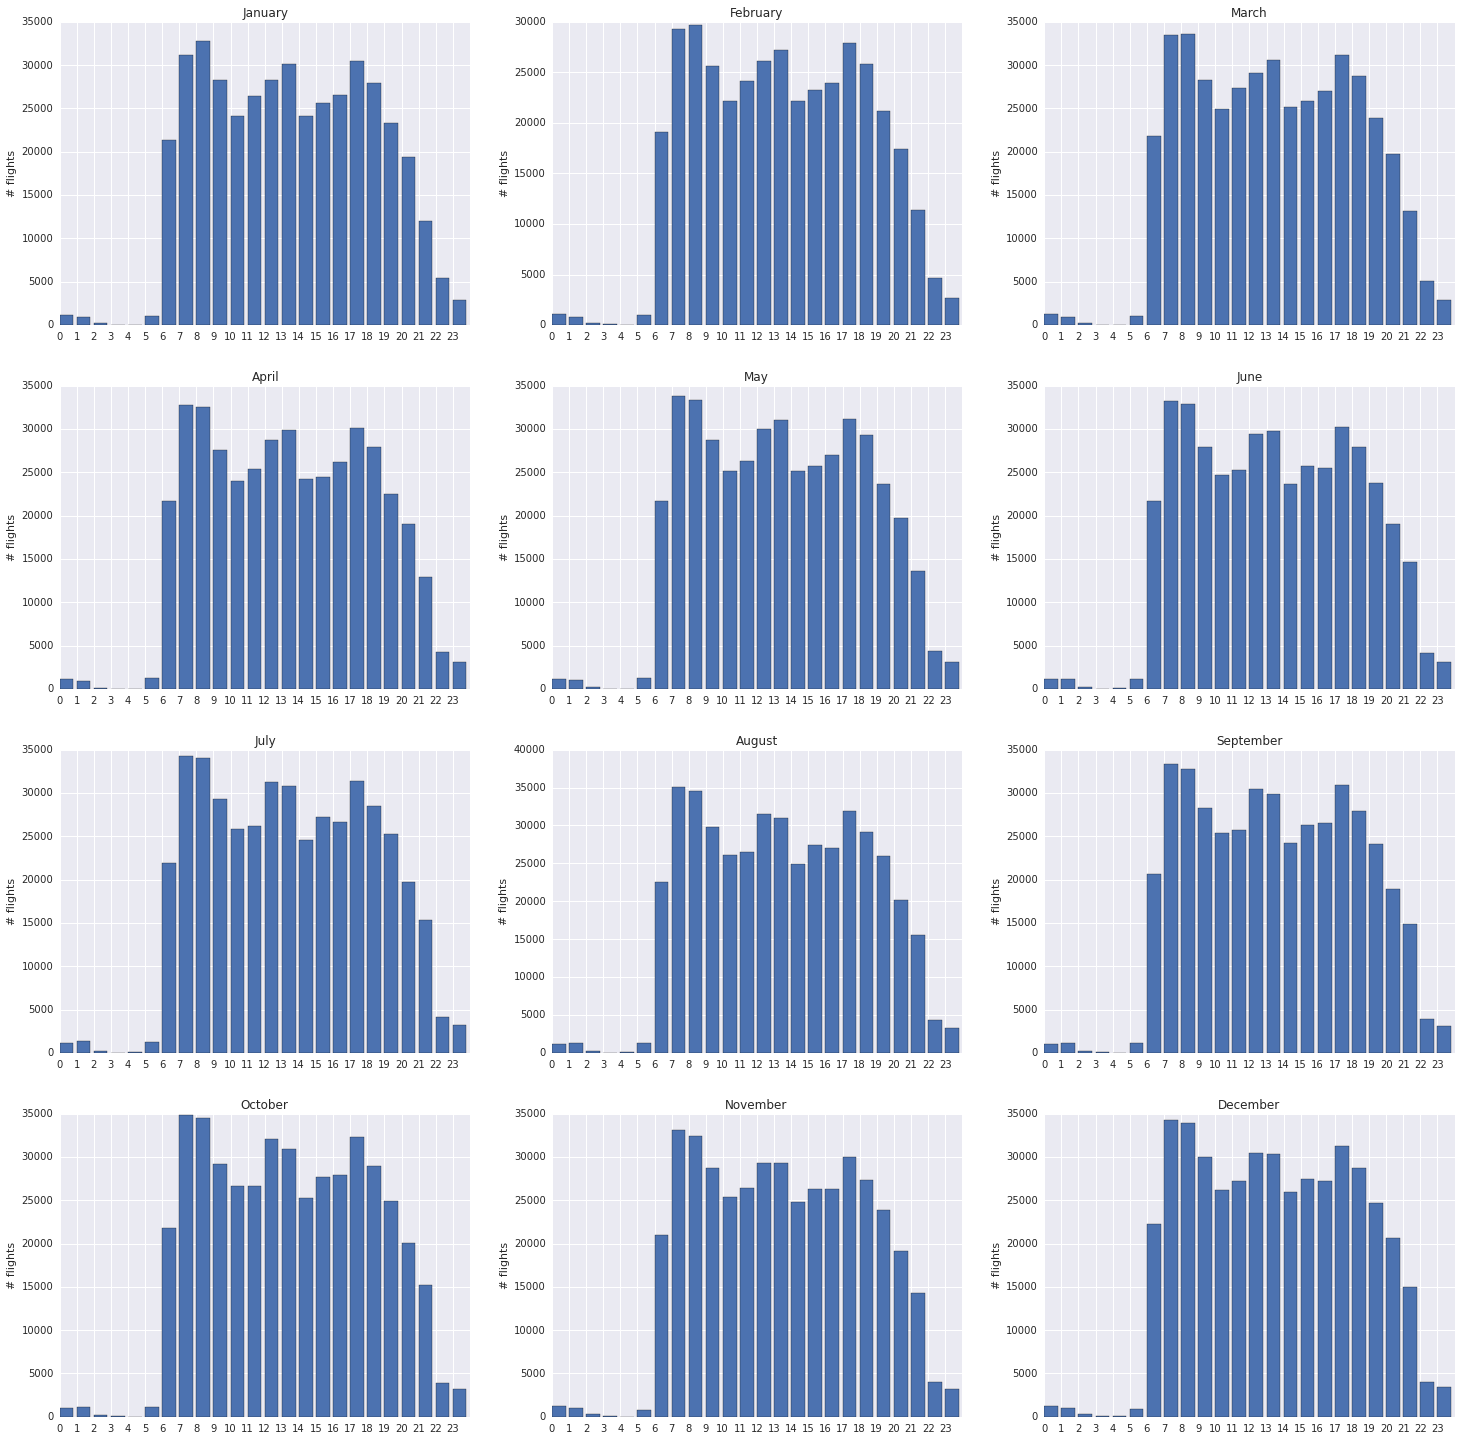

In [68]:
### FLIGHTS IN DIFFERENT HOURS OF DAY ###

# in this case, in order to group by hour, since in the database the hours are reported also considering the minutes,
# we add a column "hour_of_day", which contains the hour as an integer (from 0 to 23). so we can group by this column
# (both for global and monthly aggregates) to make the hourly groups

# NB: in the dataset there 00:00 is written as 24:00 (2400), so we do 'mod 24'
df_hour_day = df.withColumn('hour_of_day', ((df.scheduled_departure_time/100).cast('int'))%24)


### global aggregates ###

# QUERY
# groupy by hour without considering the months, then count the rows in the group to obtain the number of flights
hour_count = df_hour_day.groupBy('hour_of_day').count().orderBy('hour_of_day')


# PRINT & COLLECT
hour_count.show()
hour_count = hour_count.collect()


# PLOT
plt.figure(figsize=(15,8))
plt.bar([x for x in range(len(hour_count))], [x[1] for x in hour_count])
plt.xticks([x for x in range(len(hour_count))], [x for x in range(len(hour_count))])
plt.xlim(0, 24)
plt.title('Hour flights trend')
plt.ylabel('# Flights')
plt.show()





### monthly aggregates ###

# QUERY
# groupb by month and the added column (hour) to compute the number of flights (count) for each hour of day separated for month
monthly_hour_count = df_hour_day.groupBy(df.month, 'hour_of_day').count().orderBy(df.month,'hour_of_day')


# PRINT
monthly_hour_count.show()


# PLOT
nr = 4
nc = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    monthly_counts = monthly_hour_count[df.month == i+1].select('count').collect()
    plt.subplot(nr, nc, i+1)
    plt.bar([x for x in range(len(monthly_counts))], [x[0] for x in monthly_counts])
    plt.ylabel('# flights')
    plt.title(months[i])
    plt.xticks([p for p in range(len(monthly_counts))], [p for p in range(len(monthly_counts))])
    plt.xlim(0, len(monthly_counts))

plt.show()

In [24]:
# number of flights per day of the month per month
flights_dayofmonth_month=(
    df.groupBy(df.month, df.day_of_month)
    .count()
    .orderBy('month', 'day_of_month')
    .collect()
)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


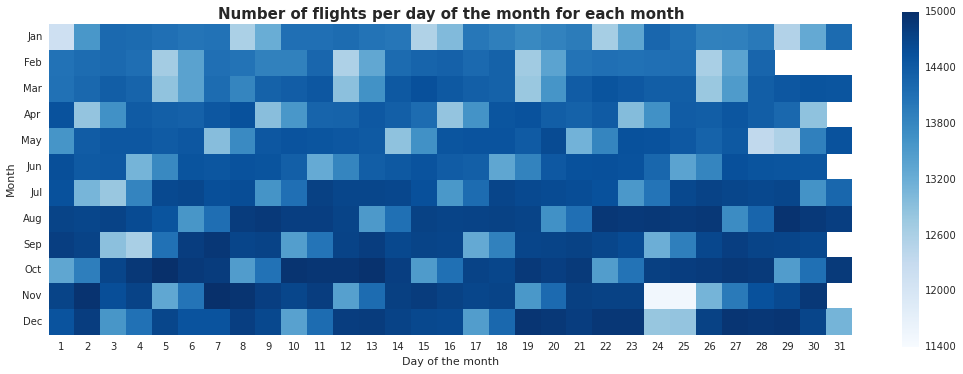

In [25]:
# create the pandas dataframe
pddf = pd.DataFrame(data=flights_dayofmonth_month,
                     columns=['month', 'day_of_month', 'flights'])

# use a heatmap to better visualize the data
pddf = pddf.pivot("month", "day_of_month", "flights")
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pddf,
            square=True,
            vmin=11400,
            vmax=15000,
            cmap='Blues')

# set plot's labels
ax.set_yticklabels(list(reversed(months)), rotation=0)
ax.set(xlabel='Day of the month', ylabel='Month')
ax.set_title("Number of flights per day of the month for each month", fontweight="bold", size=15)

plt.show()

In [26]:
# number of flights per hour
flights_hour=(
    df.groupBy(((df.scheduled_departure_time/100).cast('int')%24).alias('hour'))
    .count()
    .orderBy('hour')
    .collect()
)

[]

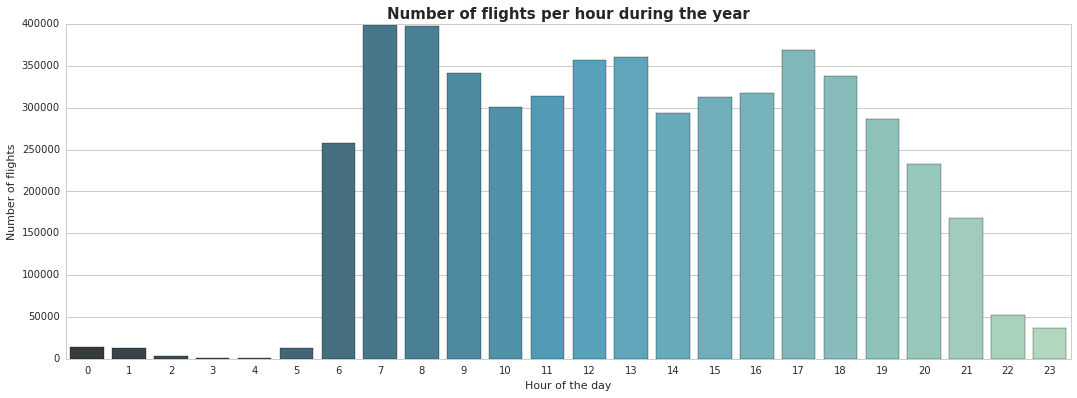

In [27]:
# create the pandas dataframe
pddf = pd.DataFrame(data=flights_hour,
                     columns=['hour', 'flights'])

# plot the number of flights per hour
f, ax = plt.subplots(figsize=(18, 6))
sns.barplot(x="hour",
            y="flights",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 24),
            ax=ax)

# set plot's labels
ax.set(xlabel='Hour of the day', ylabel='Number of flights')
ax.set_title("Number of flights per hour during the year", fontweight="bold", size=15)

plt.plot()

In [28]:
# number of flights per hour per month
flights_hour_month=(
    df.groupBy(df.month, ((df.scheduled_departure_time/100)%24).cast('int').alias('hour'))
    .count()
    .orderBy('month', 'hour')
    .collect()
)

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


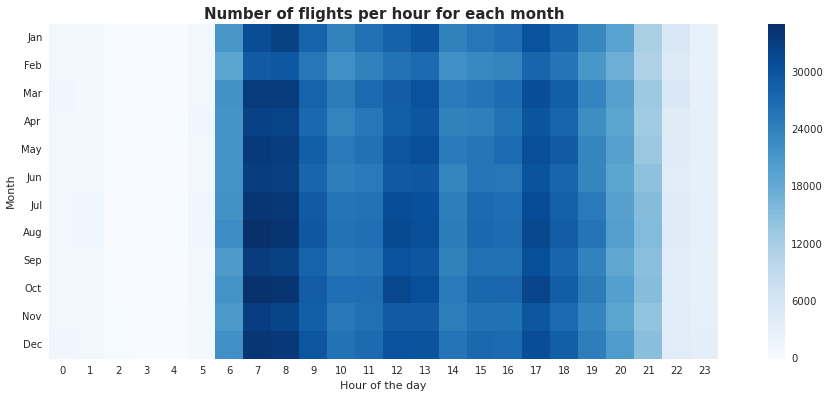

In [29]:
# create the pandas dataframe
pddf = pd.DataFrame(data=flights_hour_month,
                     columns=['month', 'hour', 'flights'])

# use a heatmap to better visualize the data
pddf = pddf.pivot("month", "hour", "flights")
f, ax = plt.subplots(figsize=(18, 6))
sns.heatmap(pddf,
            square=True,
            cmap='Blues')

# set plot's labels
ax.set_yticklabels(list(reversed(months)), rotation=0)
ax.set(xlabel='Hour of the day', ylabel='Month')
ax.set_title("Number of flights per hour for each month", fontweight="bold", size=15)

plt.show() 

### Answer 3.3

<div class="alert alert-info">
The first plot shows a stable number of flights during the days of the month. This result is expected when we look at the previous plot because by plotting the number of flights per day during the year we loose information about the day of the week and, as the plots show, this information is more relevant than the actual day of the month. Furthermore, the number of flights decreases in the last days of the months, this is due to the fact that not all the months have the same number of days (as can be noticed from the white boxes in the next plot).
<br>
<br>
The heat map shows the number of flights per day of the month for each month. The same patterns previously seen can be observed in this map too, again, under the form of lighter diagonals crossing the map. A relevant information comes out of the map: the number of flights increases in the second semester of the year. This is further confirmation of what was already seen in the first line plot about the number of flights per month.
Finally, an anomaly can be seen in the 24th and 25th of Novemeber, these days present a very low number of flights compared to the others, further information should be needed to justify this result.
<br>
<br>
Finally, the second bar plot and heat map, clearly show how, regardless of the month, the number of flights drops down at night and it reaches is maximim values between 7 and 8 AM, with other two small peaks between 12 and 13, and 17 and 18.
<br>
<br>
The last plots show also that February has a lower number of flights with respect to the other months, this information was already suggested by the previous plots showing the values per day of the week.
</div>

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [30]:
# number of outbound flights per airport
df_out_airport = (
    df.groupBy(df.src_airport.alias('airport'))
    .count()
    .orderBy('count', ascending=0)
)

# number of inbound flights per airport
df_in_airport = (
    df.groupBy(df.dest_airport.alias('airport'))
    .count()
    .orderBy('count', ascending=0)
)

# number of flights per airport
df_airport = (
    df_in_airport.union(df_out_airport)
    .groupBy('airport')
    .sum()
    .orderBy('sum(count)', ascending=0)
)

In [31]:
print("Top 20 busiest airports (outbound)")
df_out_airport.show(20)

print("Top 20 busiest airports (inbound)")
df_in_airport.show(20)

print("Top 20 busiest airports")
df_airport.show(20)

Top 20 busiest airports (outbound)
+-------+------+
|airport| count|
+-------+------+
|    ORD|277741|
|    DFW|256274|
|    ATL|221486|
|    LAX|153494|
|    STL|151609|
|    DEN|141427|
|    PHX|139581|
|    DTW|136837|
|    PIT|130977|
|    CLT|129391|
|    MSP|123222|
|    SFO|118233|
|    EWR|116768|
|    IAH|104182|
|    LGA|101864|
|    BOS|100365|
|    LAS| 94972|
|    PHL| 93585|
|    DCA| 88445|
|    MCO| 77120|
+-------+------+
only showing top 20 rows

Top 20 busiest airports (inbound)
+-------+------+
|airport| count|
+-------+------+
|    ORD|283720|
|    DFW|260249|
|    ATL|221588|
|    LAX|152959|
|    STL|152800|
|    DEN|144099|
|    PHX|140979|
|    DTW|139435|
|    PIT|131962|
|    CLT|130321|
|    MSP|124758|
|    SFO|117245|
|    EWR|117223|
|    IAH|104409|
|    LGA|101498|
|    BOS| 99331|
|    LAS| 94948|
|    PHL| 93312|
|    DCA| 87670|
|    MCO| 76600|
+-------+------+
only showing top 20 rows

Top 20 busiest airports
+-------+----------+
|airport|sum(count

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>

In [32]:
# number of flights per carrier
df_carrier = (
    df.groupBy(df.carrier)
    .count()
    .orderBy('count', ascending=0)
)

In [33]:
df_carrier.show(20)

+-------+------+
|carrier| count|
+-------+------+
|     DL|874526|
|     US|857906|
|     AA|722277|
|     UA|638750|
|     WN|565426|
|     CO|484834|
|     NW|482798|
|     TW|258205|
|     HP|177851|
|     AS|117475|
+-------+------+



## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

In [34]:
# number of delayed flights per hour
df_flights_hour_delay = df[df.arrival_delay > 15].groupBy((df.scheduled_departure_time/100).cast('int').alias('hour')).count()

# number of flights per hour
df_flights_hour = df.groupBy((df.scheduled_departure_time/100).cast('int').alias('hour')).count()

# percentage of flight in delay per hour
percentage_hour_delay = (
    df_flights_hour.join(df_flights_hour_delay, df_flights_hour.hour == df_flights_hour_delay.hour, 'inner')
    .select(df_flights_hour.hour, df_flights_hour_delay['count']*100/df_flights_hour['count'])
    .orderBy('hour')
    .collect()
)

[]

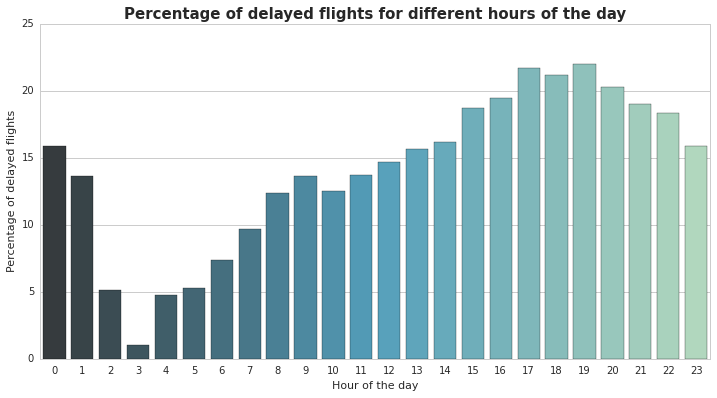

In [35]:
# create the pandas dataframe
pddf = pd.DataFrame(data=percentage_hour_delay,
                     columns=['hour', 'flights'])

# plot the percentage of flights in delay per hour
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="hour",
            y="flights",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 24),
            ax=ax)

# set plot's labels
ax.set(xlabel='Hour of the day', ylabel='Percentage of delayed flights')
ax.set_title("Percentage of delayed flights for different hours of the day", fontweight="bold", size=15)

plt.plot()

### Answer 4.1
<div class="alert alert-info">
This plot shows that, even if the previous plot showed a very low number of flights at night, there a not-indifferent percentage of delayed flights in the late hours (up to 16%). In particular, it can easily be noticed that the percentage starts to increase at 3 AM and reaches its maximum values between 17 and 19 (more than one flight out of five), then it decreases again.
To get a better understanding of the delays it would be useful to have statistics about the actual value of the delay (next plots).
</div>

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

In [36]:
# average delay per hour
hour_avg_delay = (
    df.groupBy(((df.scheduled_departure_time/100)%24).cast('int').alias('hour'))
    .avg('arrival_delay')
    .orderBy('hour')
    .collect()
)

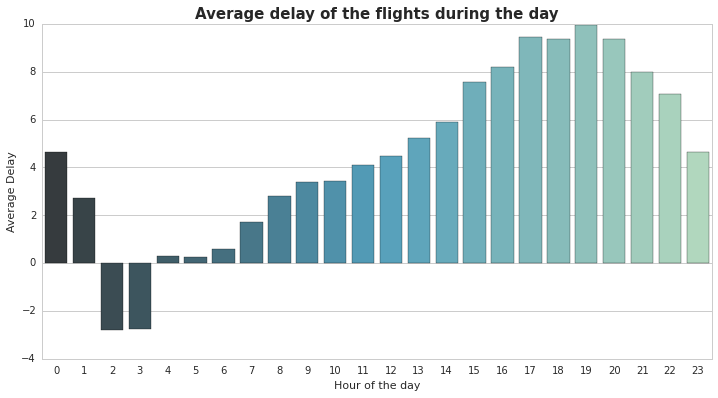

In [37]:
# create the pandas dataframe
pddf = pd.DataFrame(data=hour_avg_delay,
                     columns=['hour', 'avg'])

# plot the avg number of flights in delay per hour
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="hour",
            y="avg",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 24),
            ax=ax)

# set plot's labels
ax.set(xlabel='Hour of the day', ylabel='Average Delay')
ax.set_title("Average delay of the flights during the day", fontweight="bold", size=15)

plt.show()

### Answer 4.2
<div class="alert alert-info">
From the average number of delayed flights per hour it can be noticed that night hours have the smallest average delays and this value increases over time until it reaches it maximum at 19. This information is coherent with what we've already seen, infact we know that night hours have less flights and the shape of this curve to the one of the previous one so we can say that there could be a correlation between the percentage of delayed flights and the average value of the delay. 
</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

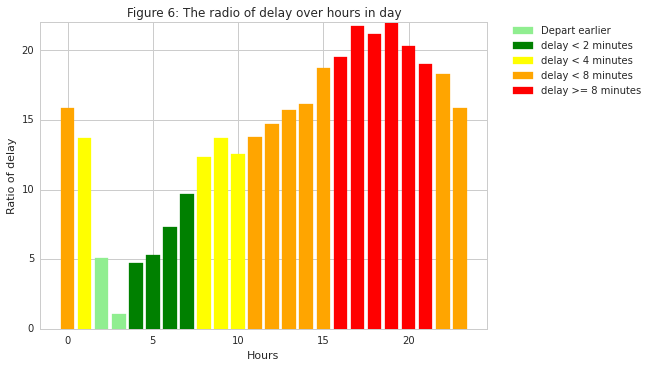

In [38]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
pdf_delay_ratio_per_hour = pd.DataFrame(data=percentage_hour_delay)
pdf_mean_delay_per_hour = pd.DataFrame(data=hour_avg_delay)
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.margins(0.05, 0)
plt.show()

In the new figure (Figure 6), we have more information in a single plot. The flights in 3AM to 4AM have very low probability of being delayed, and actually depart earlier than their schedule. In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.

This example shows us that the way representing results are also important.


### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

In [39]:
# number of delayed flights per day of the month
df_daymonth_delayed = (
    df[df.arrival_delay > 15]
    .groupBy(df.day_of_month)
    .count()
)

# number of flights per day of the month
df_daymonth = df.groupBy(df.day_of_month).count()

# percentage of delayed flights per day of the month
percentage_daymonth_delay = (
    df_daymonth.join(df_daymonth_delayed, df_daymonth.day_of_month == df_daymonth_delayed.day_of_month, 'inner')
    .select(df_daymonth.day_of_month, df_daymonth_delayed['count']*100/df_daymonth['count'])
    .orderBy('day_of_month')
    .collect()
)

[]

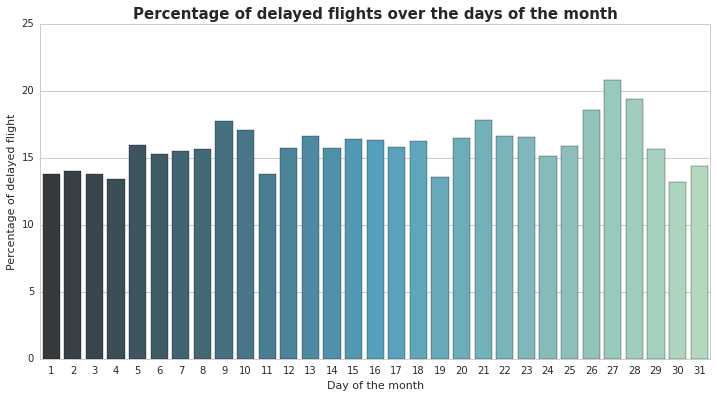

In [40]:
# create the pandas dataframe
pddf = pd.DataFrame(data=percentage_daymonth_delay,
                     columns=['day_of_month', 'percentage'])

# plot the number of delayed flights per day of the month
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="day_of_month",
            y="percentage",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 31),
            ax=ax)

# set plot's labels
ax.set(xlabel='Day of the month', ylabel='Percentage of delayed flight')
ax.set_title("Percentage of delayed flights over the days of the month", fontweight="bold", size=15)

plt.plot()

### Answer 4.3

<div class="alert alert-info">
The percentage of delayed flights oscillates around 15% over the whole month. It can be noticed that the value has small periodical drops, probably related to the day of the week, and it generally increases, reaching its peak, at the end of the month.
As already discussed, the values from the 29th to the 31st have to be taken in consideration carefully because not all the months have records for these days.
</div>

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

In [41]:
# number of delayed flights per day of the week
df_dayweek_delayed = df[df.arrival_delay > 15].groupBy(df.day_of_week).count()

# number of flights per day of the week
df_dayweek = df.groupBy(df.day_of_week).count()

# percentage of delayed flights per hour
percentage_dayweek_delay = (
    df_dayweek.join(df_dayweek_delayed, df_dayweek.day_of_week == df_dayweek_delayed.day_of_week, 'inner')
    .select(df_dayweek.day_of_week, df_dayweek_delayed['count']*100/df_dayweek['count'])
    .orderBy('day_of_week')
    .collect()
)

[]

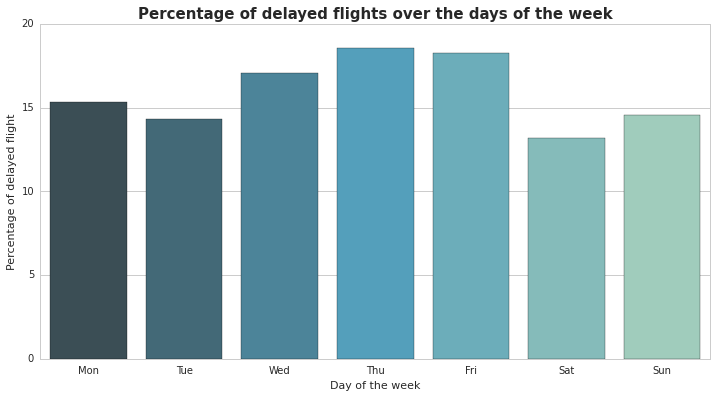

In [42]:
# create the pandas dataframe
pddf = pd.DataFrame(data=percentage_dayweek_delay,
                     columns=['day_of_week', 'percentage'])

# plot the number of delayed flights per day of the month
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="day_of_week",
            y="percentage",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 7),
            ax=ax)

# set plot's labels
ax.set(xlabel='Day of the week', ylabel='Percentage of delayed flight')
ax.set_xticklabels(daysofweek)
ax.set_title("Percentage of delayed flights over the days of the week", fontweight="bold", size=15)

plt.plot()

### Answer 4.4

<div class="alert alert-info">
As expected from the previous plot, the percentage of delayed flights is higher in the middle of the week, while it decreases at the beginning and at the end. This is probably what creates the bigger oscillations in the days-of-the-month plot.
Furthermore it can be noted that the percentage of delayed lights drops to its minimum value in the weekend, where we know from  the previous plots that there are less flights.
</div>

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

In [43]:
# number of delayed flights per month
df_month_delayed = (
    df[df.arrival_delay > 15]
    .groupBy(df.month)
    .count()
)

# number of flights per month
df_month = df.groupBy(df.month).count()

# percentage of delayed flights per hour
percentage_month_delay = (
    df_month.join(df_month_delayed, df_month.month == df_month_delayed.month, 'inner')
    .select(df_month.month, df_month_delayed['count']*100/df_month['count'])
    .orderBy('month')
    .collect()
)

[]

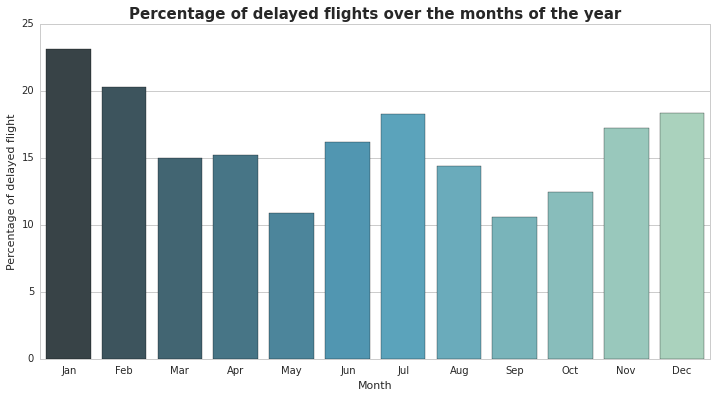

In [44]:
# create the pandas dataframe
pddf = pd.DataFrame(data=percentage_month_delay,
                     columns=['month', 'percentage'])

# plot the number of delayed flights per month
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="month",
            y="percentage",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 12),
            ax=ax)

# set plot's labels
ax.set(xlabel='Month', ylabel='Percentage of delayed flight')
ax.set_xticklabels(months)
ax.set_title("Percentage of delayed flights over the months of the year", fontweight="bold", size=15)

plt.plot()

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [45]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

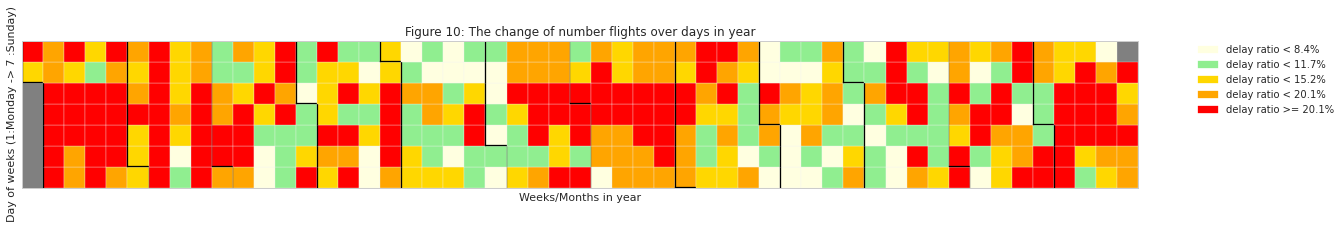

In [46]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Answer 4.5
<div class="alert alert-info">
From the barplot is possible to notice that the highest percentage of delays is in December, January, February (probably because fo the weather, it will be analysed later) and July.
Moreover May and September are the best months to fly because they have the lowest percentage of delayes, this is probably not true in France because of all the different factors that have to be taken into consideration to end up with such a conclusion (weather, holidays...).
</div>

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

In [47]:
# top 20 busiest airports
df_busiest_airports = df_airport.limit(20)

# number of delayed flights in the top 20 busiest airport
df_delays_busiest_src_airports = (
    df[(df.src_airport.isin([x[0] for x in df_busiest_airports.collect()])) & (df.arrival_delay > 15)]
    .groupBy(df.src_airport)
    .count()
)
df_delays_busiest_dest_airports = (
    df[(df.dest_airport.isin([x[0] for x in df_busiest_airports.collect()])) & (df.arrival_delay > 15)]
    .groupBy(df.dest_airport)
    .count()
)

# delay probability per source
df_prob_delay_busiest_src = (
    df_delays_busiest_src_airports.
    join(df_busiest_airports, df_busiest_airports.airport == df_delays_busiest_src_airports.src_airport, "inner").
    select(df_busiest_airports.airport, (df_delays_busiest_src_airports["count"]/df_busiest_airports["sum(count)"]).alias("probability")).
    orderBy('airport')
)
# delay probability per destination
df_prob_delay_busiest_dest = (
    df_delays_busiest_dest_airports.
    join(df_busiest_airports, df_busiest_airports.airport == df_delays_busiest_dest_airports.dest_airport, "inner").
    select(df_busiest_airports.airport, (df_delays_busiest_dest_airports["count"]/df_busiest_airports["sum(count)"]).alias("probability")).
    orderBy('airport')
)

# delay propability per source and destination
prob_delay_busiest_any = (
    df_prob_delay_busiest_src.
    join(df_prob_delay_busiest_dest, df_prob_delay_busiest_src.airport == df_prob_delay_busiest_dest.airport, "inner").
    select(df_prob_delay_busiest_src.airport, ((df_prob_delay_busiest_src["probability"]+df_prob_delay_busiest_dest["probability"])/2).alias("probability")).
    orderBy('probability').
    collect()
)

prob_delay_busiest_src = df_prob_delay_busiest_src.collect()
prob_delay_busiest_dest = df_prob_delay_busiest_dest.collect()

[]

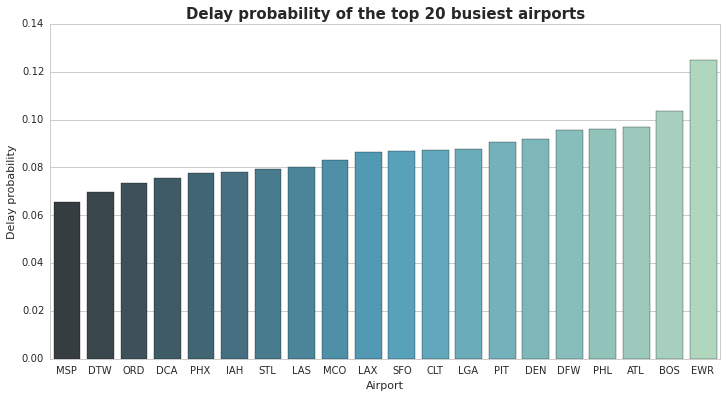

In [48]:
# create the pandas dataframe
pddf = pd.DataFrame(data=prob_delay_busiest_any,
                     columns=['airport', 'probability'])

# plot 
f, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x="airport",
            y="probability",
            data=pddf,
            palette=sns.color_palette("GnBu_d", 20),
            ax=ax)
ax.set(ylabel="All", xlabel="Airport")
ax.set(ylabel="Delay probability", xlabel="Airport")
ax.set_title("Delay probability of the top 20 busiest airports", fontweight="bold", size=15)

plt.plot()

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

Delay probability and flight volume for top busiest carriers:
+-------+------+-------------------+
|carrier| count|        delay_ratio|
+-------+------+-------------------+
|     AS|117475| 0.1596424771227921|
|     HP|177851|0.18625141269939444|
|     TW|258205|0.18212273193780135|
|     NW|482798| 0.1294806523639286|
|     CO|484834| 0.1955576547849367|
|     WN|565426|0.12829795587751536|
|     UA|638750| 0.1686528375733855|
|     AA|722277| 0.1752444006939166|
|     US|857906|0.18422298014001534|
|     DL|874526|0.18328443065157582|
+-------+------+-------------------+



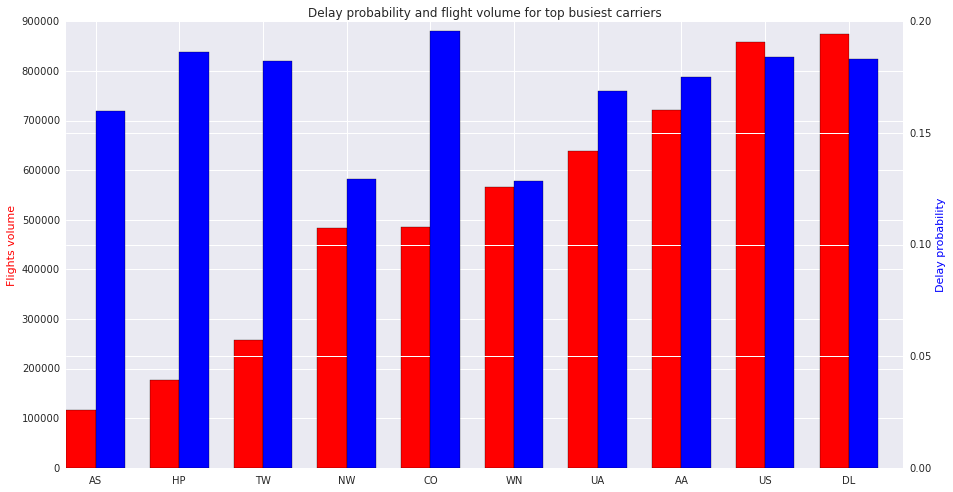

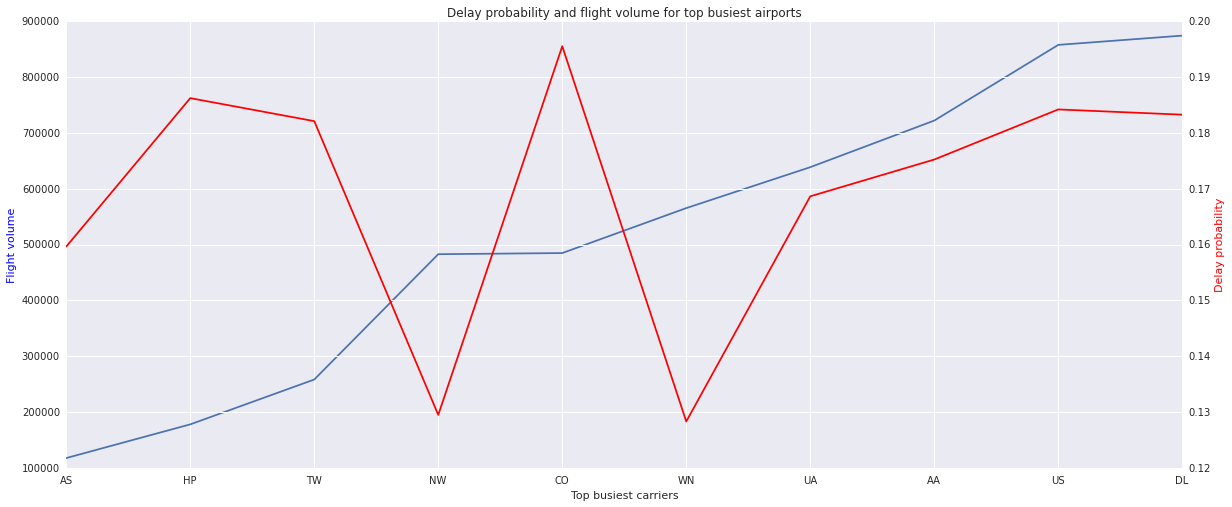

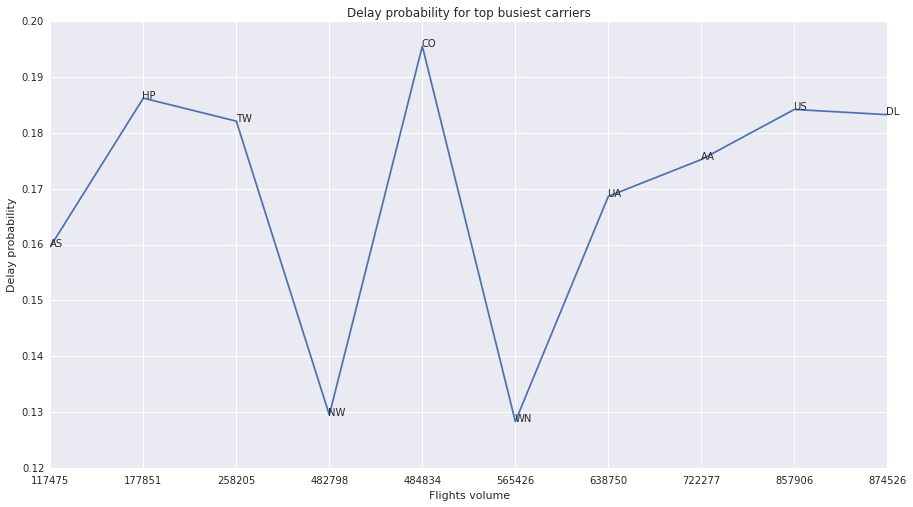

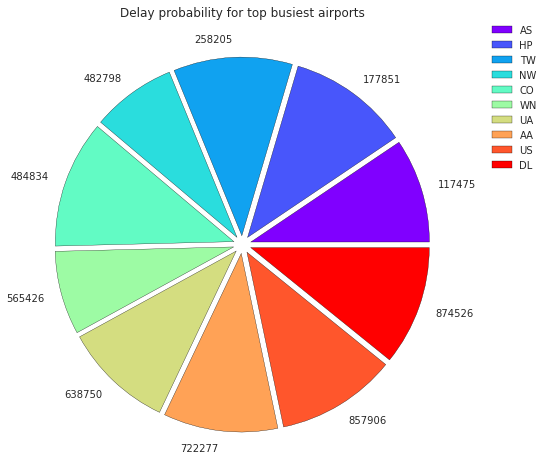

In [35]:
# here we reused the top_busiest_carriers dataframe computed in the cell 3.5
# it contains the top busiest carriers ordered in descending order of number of flights
# the code is reported here for clarity reasons:

# top_busiest_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
# top_busiest_carriers.show()

# take the first 20 lines from the dataframe and put them into a list (to be used by the 'isin' function)
# NB: there are only 10 carriers in the 1994 dataset
top_c = top_busiest_carriers.take(20)
top_c = [x[0] for x in top_c]


# QUERY
# filter the original dataframe and add the is_delay column as we did also in the previous questions
df_with_delay = df.filter(df.carrier.isin(top_c)).withColumn('is_delay', func.when((df["arrival_delay"] >= 15), 1).otherwise(0))
# then group by carrier, and for each carrier, compute the delay ratio
statistic_day = df_with_delay.groupBy(df.carrier)\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('delay_ratio')


# PRINT & COLLECT
print('Delay probability and flight volume for top busiest carriers:')
data = top_busiest_carriers.join(statistic_day, on='carrier').select('*').orderBy('count')
data.show()
data = data.collect()


# PLOT (bar chart)
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
ax.bar([x for x in range(len(data))], [x[1] for x in data], 0.35, color='r')
ax.set_ylabel('Flights volume', color='r')
ax2 = ax.twinx()
ax2.bar([x+0.35 for x in range(len(data))], [x[2] for x in data], 0.35, color='b')
ax2.set_ylabel('Delay probability', color='b')
plt.xticks([x+0.35 for x in range(len(data))], [x[0] for x in data])
plt.title('Delay probability and flight volume for top busiest carriers')
plt.show()

# PLOT (line chart with x=airport, y1=flight volume, y2=delay)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_title('Delay probability and flight volume for top busiest airports')
ax.plot([x for x in range(len(data))], [x[1] for x in data])
ax.set_xlabel('Top busiest carriers')
ax.set_ylabel('Flight volume', color='b')
ax2 = ax.twinx()
ax2.plot([x for x in range(len(data))], [x[2] for x in data], c='r')
ax2.set_ylabel('Delay probability', color='r')
plt.xticks([x for x in range(len(data))], [x[0] for x in data])
plt.show()

# PLOT (line chart)
plt.figure(figsize=(15,8))
plt.plot([x for x in range(len(data))], [x[2] for x in data])
plt.xticks([x for x in range(len(data))], [x[1] for x in data])
for x in range(len(data)):
    plt.annotate('%s' % data[x][0], xy=(x, data[x][2]))
plt.title('Delay probability for top busiest carriers')
plt.ylabel('Delay probability')
plt.xlabel('Flights volume')
plt.show()

# PLOT (pie chart)
plt.figure(figsize=(8,8))
patches, _ =plt.pie([x[2] for x in data], 
        explode=[0.05 for _ in range(len(data))], 
        colors=cm.rainbow(np.linspace(0, 1, len(data))), 
        labels=[x[1] for x in data])
plt.legend(patches, [x[0] for x in data], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Delay probability for top busiest airports')
plt.show()

### Answer 4.7

<div class="alert alert-info">
We have produced different kind of plots (the same as before).
<br><br>
Also in this case we can say that there is not a strict correlation between the flight volume and the probability of delay among carriers.<br>
The carrier with the highest **delay probability** (0.19/0.20) in this case is **CO**, which registers around 485k flights per year, while the one with the lowest delays is WN, with 565k flights per year.<br>
In the meanwhile **DL** is the carrier with the highest **flight volume**, with a value around 874K per year, that is close to the double of the CO one, but has a delay probability of 0.18.<br>
So also here we can say that there are carriers that are more organized that others and are able to better manage delays.
</div>

### Question 4.8: 

<div class="alert alert-info">
Is there a relation between the distance of flight and the delay?
</div>

In [54]:
df_delay_distance = (df[df.distance.isNotNull()][df.arrival_delay>0]
                     .select(df.distance, df.arrival_delay)
                     .orderBy(df.distance, df.arrival_delay))
delay_distance=df_delay_distance.collect()

In [64]:
# create the pandas dataframe
pddf = pd.DataFrame(data=delay_distance,
                     columns=['arrival_delay', 'distance'])

[]

/opt/conda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


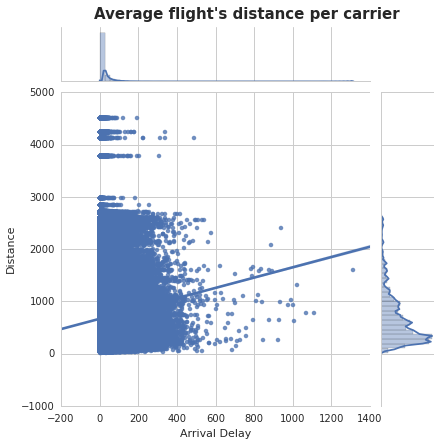

In [66]:
# plot the average distance per carrier
ax=sns.jointplot("distance", "arrival_delay", stat_func=None, data=pddf, kind="reg")

# set plot's labels
ax.set_axis_labels('Arrival Delay', 'Distance')
ax.fig.get_axes()[0].set_title("Average flight's distance per carrier", fontweight="bold", size=15)
ax.fig.get_axes()[0].title.set_position([0.6,1.22])

plt.plot()

### Comments 

<div class="alert alert-info">
The first plot shows three main different categories based on the average flight's distance. Most of the carriers fall in the central category, having average flight's distance of approximately 650 km, then the other two categories present smaller (400-500 km) and greater (~950 km) distances.
<br>
Since the previous plots showed almost no correlation between the delay and the carrier of a flight, we decided to use a regression plot to check if there is a correlation between distance and delay. This last plot showed a correlation between the two measures: as the distance of flight increases, the delay increases too.
</div>

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

In [57]:
src_airports = df.select(df.src_airport)
dest_airports = df.select(df.dest_airport)

# airports present only as destination
dest_not_src = dest_airports.subtract(src_airports)

# airports present only as origin
src_not_dest = src_airports.subtract(dest_airports)

In [58]:
dest_not_src.show()
src_not_dest.show()

+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+

+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+



### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

</div>

In [59]:
#Calculate the amount of delayed flights in the top 20 busiest airport
delays_src_airports=df[df.arrival_delay > 15].groupBy(df.src_airport).count()
delays_dest_airports=df[df.arrival_delay > 15].groupBy(df.dest_airport).count()

#Calculate the probability per source and per destination
p_delay_src=(
    delays_src_airports.
    join(df_airport, df_airport.airport == delays_src_airports.src_airport, "inner").
    select(df_airport.airport, (delays_src_airports["count"]/df_airport["sum(count)"]).alias("probability"))
)
p_delay_dest=(
    delays_dest_airports.
    join(df_airport, df_airport.airport == delays_dest_airports.dest_airport, "inner").
    select(df_airport.airport, (delays_dest_airports["count"]/df_airport["sum(count)"]).alias("probability"))
)

#Calculate the propability of delay regardless if the airport is source or destination and sort the results
p_delay_any=(
    p_delay_src.
    join(p_delay_dest, p_delay_src.airport == p_delay_dest.airport, "inner").
    select(p_delay_src.airport, ((p_delay_src["probability"]+p_delay_dest["probability"])/2).alias("probability")).
    orderBy("probability", ascending=0)
)

In [60]:
#Show top 10 airports in delay probability
p_delay_any.show(10)

+-------+-------------------+
|airport|        probability|
+-------+-------------------+
|    MTJ|0.16666666666666666|
|    ACK|0.15476190476190477|
|    GUC|0.13365155131264916|
|    EWR|0.12512874426794193|
|    BFL| 0.1206896551724138|
|    PFN|0.11978150604760046|
|    JFK| 0.1175976942309473|
|    EGE|0.11706881143878463|
|    BQN| 0.1154970760233918|
|    BOS|0.10369010896562775|
+-------+-------------------+
only showing top 10 rows



<div class="alert alert-info">

Which cities have largest delay duration in average ?

</div>

In [61]:
#Create DataFrame for cities
df_cities = sqlContext.read.load('airports.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

#Calculate the average delay duration and sort the results
city_delay=df.join(df_cities, df.dest_airport==df_cities.iata, "inner").groupBy(df_cities.city).agg(func.avg(df.arrival_delay).alias("avg_delay")).orderBy("avg_delay", ascending=0)

In [62]:
#Show top 10 cities in delay duration
city_delay.show(10)

+--------------+------------------+
|          city|         avg_delay|
+--------------+------------------+
|     Nantucket|              20.0|
|      Montrose|17.352941176470587|
|   Bakersfield|13.368070953436806|
|        Newark|12.523816300934863|
|     Lafayette| 11.64069264069264|
|    St. Mary's|11.181818181818182|
|     Aguadilla| 10.39760837070254|
|    Petersburg|10.231907894736842|
|Grand Junction|10.088669950738916|
|      Gunnison|10.014218009478673|
+--------------+------------------+
only showing top 10 rows



### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>

In [42]:
# MONTHLY ANALYSIS

# as said before, we have considered the top busiest airport in our analysis
# those have been computed in the cell 3.4. the code to compute them is reported for clarity reasons:
#df_airport = df.withColumn('airport', df.Origin).union(df.withColumn('airport', df.Dest))
#top_busiest_airport = df_airport.groupBy('airport').count().orderBy('count', ascending=0)

# we take the first 10 busiest airports
top_10 = top_busiest_airport.take(10)
top_10 = [x[0] for x in top_10]

# following the same approach used in the question 4.6, we filter the dataframe with the top busiest airports
# and then we add as usual the is_delay column
df_with_delay = df_airport.filter(df_airport.airport.isin(top_10)).withColumn('is_delay', func.when((df_airport.ArrDelay >= 15), 1).otherwise(0))
# make a group for each airport and month (because we wanto to perform a monthly analysis for each airport)
# and compute the delay ratio. in this way we have the delay ratio for each month and airport
df_with_delay = df_with_delay.groupBy(df_with_delay.airport, df_with_delay.Month)\
                 .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))
    
# join with the weather database to obtain the dataframe with also the weather informations
df_with_weather = df_with_delay.withColumnRenamed('Month', 'month').join(weather_df, ['airport', 'month'])

# and compute average weather conditions for each month and airport
# we group by delay reatio only to keep the column in the resulting table
df_with_weather = df_with_weather.groupBy('airport', 'month', 'delay_ratio').agg(
    func.avg('meantempm').alias('mean_temp'), func.sum('precipm').alias('mean_precip'), func.avg('meanwindspdm').alias('mean_wind')).orderBy('airport','month')

df_with_weather.show()

+-------+-----+-------------------+------------------+------------------+------------------+
|airport|month|        delay_ratio|         mean_temp|       mean_precip|         mean_wind|
+-------+-----+-------------------+------------------+------------------+------------------+
|    ATL|    1|0.27180255073062426|3.4838709677419355| 84.82000000000001| 10.67741935483871|
|    ATL|    2|0.23665616753213586| 8.785714285714286|            147.33| 9.464285714285714|
|    ATL|    3|0.21848953686947212|12.387096774193548|146.06000000000003|10.483870967741936|
|    ATL|    4|0.20534770661593743|17.833333333333332|             90.93| 6.433333333333334|
|    ATL|    5|0.15487403025349628|18.774193548387096| 59.44999999999999| 5.064516129032258|
|    ATL|    6| 0.2387718208010847|24.566666666666666|             89.93| 4.133333333333334|
|    ATL|    7|0.28473177441540576|23.870967741935484|279.40999999999997| 3.903225806451613|
|    ATL|    8| 0.1868933355024131|23.870967741935484| 81.789999999999

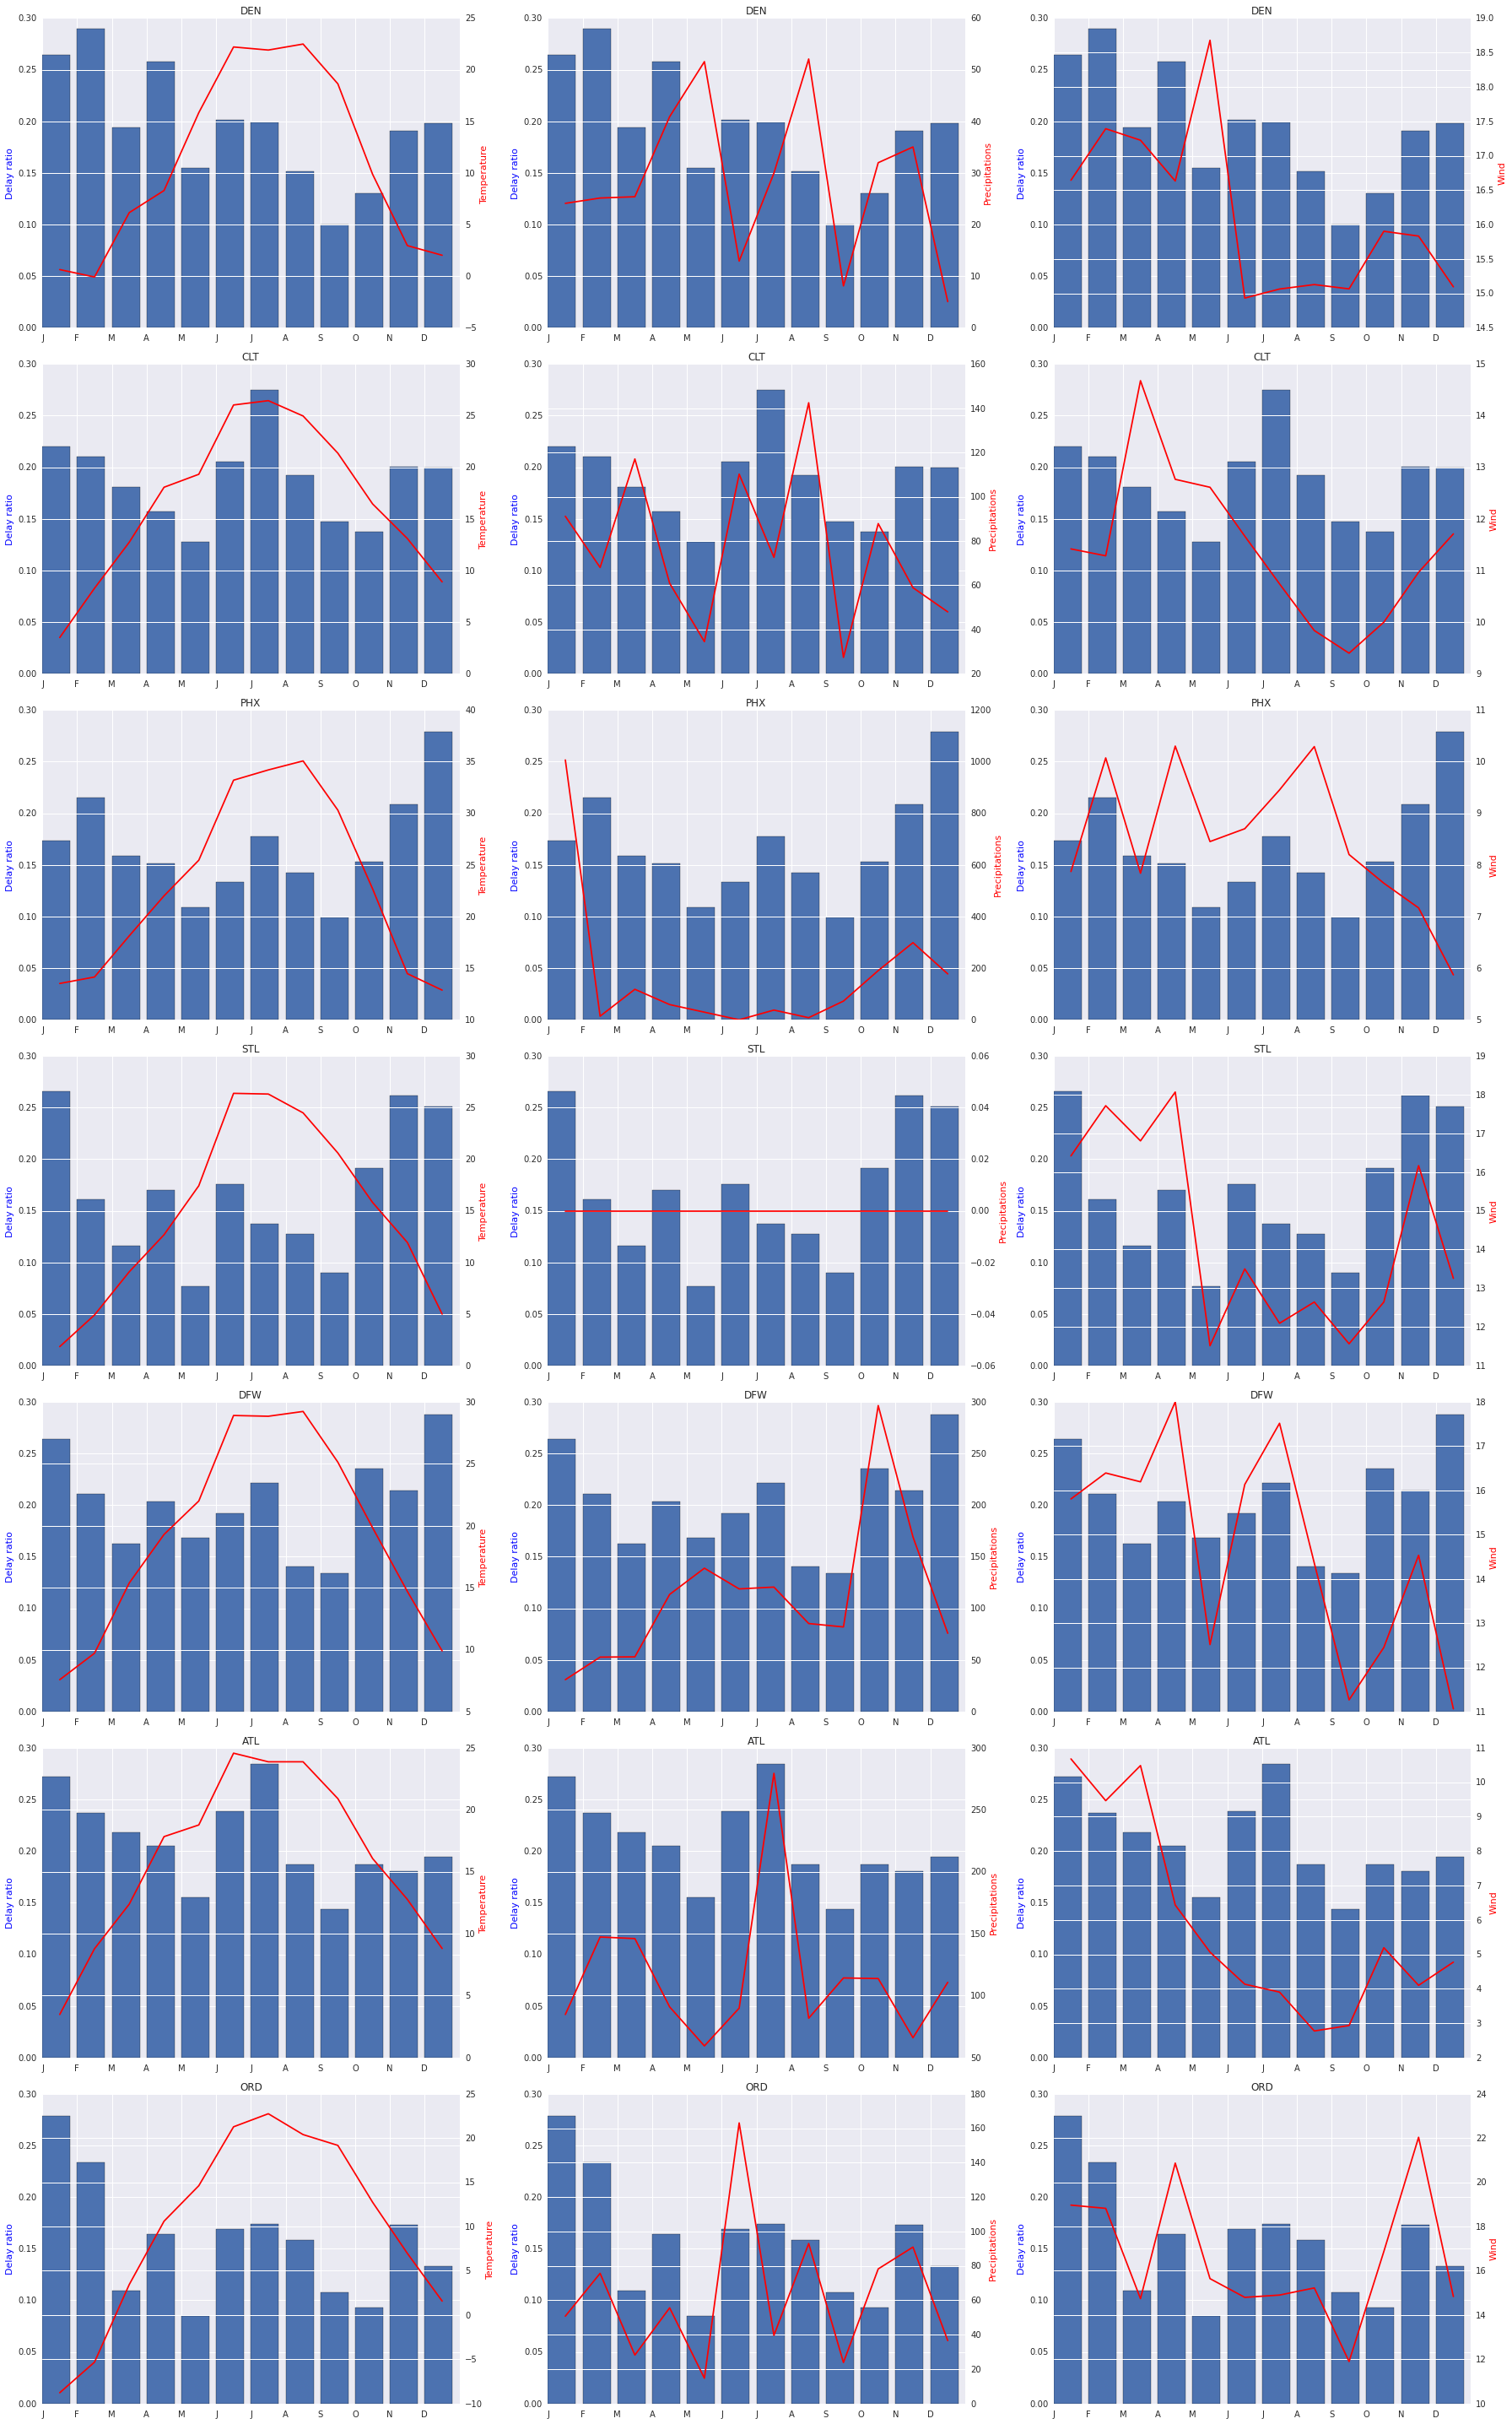

In [43]:
def condition_plot(ax, delays, conditions, y1label, y2label):
    ax.bar([x for x in range(len(delays))], [x[0] for x in delays])
    ax.set_ylabel(y1label, color='b')
    ax2 = ax.twinx()
    ax2.plot([x+0.5 for x in range(len(conditions))], [x[0] for x in conditions], color='r')
    ax2.set_ylabel(y2label, color='r')


airports = df_with_weather.select('airport').distinct().collect()
airport_found = len(airports)

# PLOT
# one plot for each airport and weather condition. so 3 plots (columns) avg(meantempm) avg(precipm) avg(meanwindspdm) and airport_found rows
nr = airport_found
nc = 3
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

plt.figure(figsize=(25, 40))
plot_counter = 1
for airport in airports:
    df_curr_airport = df_with_weather[df_with_weather.airport == airport[0]]
    delays = df_curr_airport.select('delay_ratio').collect()
    mean_temp = df_curr_airport.select('mean_temp').collect()
    mean_precip = df_curr_airport.select('mean_precip').collect()
    mean_wind = df_curr_airport.select('mean_wind').collect()
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_temp, 'Delay ratio', 'Temperature')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_precip, 'Delay ratio', 'Precipitations')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1
    
    ax = plt.subplot(nr, nc, plot_counter)
    condition_plot(ax, delays, mean_wind, 'Delay ratio', 'Wind')
    plt.title(airport[0])
    plt.xticks([x for x in range(len(months))], [x[0] for x in months], rotation='vertical')
    plot_counter += 1

plt.tight_layout()
plt.show()

### Answer 5.3

<div class="alert alert-info">
The first plot shows the percentage of delayed flights that occured under each weather condition. 
The second plot instead shows a slight correlation between delay's duration and weather.
The weather data have been extracted from a dataset taking into consideration only the top 20 busiest airports during the year.
<br><br>
Apart from the temperature, that seems not to affect too much the delay, correlation with precipitation is relatively high: about 20% of delays have been experienced under circumstances of rain, and the duration of such delays seems to be longer when the intensity is extremely high, i.e. thunders, as shown by the correlation index. 
<br>
Snow instead presents an unexpected behaviour, since the correlation seems to suggest a lower influence on the delay duration. Moreover, the analysis in terms of percentages shows a low rate as well, but in this case it is necessary to take into account that snow is an event extremely more rare than rain or strong wind in most part of the worlds.

</div>